# Project 5: Profit Percent Prediction

In [1]:
# load the necessary packages

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import numpy as np
import pickle 

import matplotlib.pyplot as plt
# %matplotlib inline

import seaborn as sns
sns.set_style("whitegrid", {"font.family": ["serif"]})
sns.set_context("talk")

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

Populating the interactive namespace from numpy and matplotlib


## scores dataset cleaning

In [2]:
# customer credit scores and payment delinquency data
scores = pd.read_excel('FINPAC_Data/Delinquency and Scores.xlsx', index_col=0)

In [4]:
# rename the columns to more Pythonic names
scores.rename(columns={'Equipment Cost': 'equipment_cost', 'Times Delinquent': 'times_delinq', 
                               'Delinquent 31 days': 'delinq_31', 'Delinquent 91 days': 'delinq_91', 
                               'App Score': 'app_score', 'Beacon Score': 'beacon_score'}, inplace=True)

In [5]:
# name the index 'contract_num' for future merging
scores.index.names = ['contract_num']

In [6]:
# change missing values (NaNs) in following features to zero (0)
scores['times_delinq'].fillna(0, inplace = True)
scores['delinq_31'].fillna(0, inplace = True)
scores['delinq_91'].fillna(0, inplace = True)

In [7]:
# check for missing values
print(scores.equipment_cost.isna().sum())
print(scores.times_delinq.isna().sum())
print(scores.delinq_31.isna().sum())
print(scores.delinq_91.isna().sum())
print(scores.app_score.isna().sum())
print(scores.beacon_score.isna().sum())

0
0
0
0
1577
1527


In [97]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49542 entries, 001-0002253-307 to 099-1529278-002
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   equipment_cost  49542 non-null  float64
 1   times_delinq    49542 non-null  float64
 2   delinq_31       49542 non-null  float64
 3   delinq_91       49542 non-null  float64
 4   app_score       47965 non-null  float64
 5   beacon_score    48015 non-null  float64
dtypes: float64(6)
memory usage: 2.6+ MB


## demographics dataset cleaning

In [9]:
# customer demographic data: city, state, zip, etc.
demo = pd.read_excel('FINPAC_Data/Demographics.xlsx', index_col=0)

In [11]:
# drop columns
demo.drop(columns=['Delinquency Status', 'Broker Name'], inplace=True)

In [12]:
# name the index 'contract_num' for future merging
demo.index.names = ['contract_num']

In [13]:
# rename columns
demo.rename(columns={'City': 'city', 'State': 'state', 'Zip': 'zip', 'Broker Num': 'broker_num'}, inplace=True)

## Feature engineering of region in demographics dataset

In [14]:
# find unique state abbreviations. DC and 6 Canadian Provinces (NB, ON, PE, QC, MB, BC)
demo.state.nunique()

57

In [15]:
# create the region lists from States
ne_lst = ['CT', 'DE', 'MA', 'ME', 'NB', 'NH', 'NJ', 'NY', 'ON', 'PA', 'PE', 'QC', 'RI', 'VT']
se_lst = ['AK', 'AL', 'AR', 'DC', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']
mw_lst = ['IA', 'IL', 'IN', 'KS', 'MB', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
sw_lst = ['AZ', 'NM', 'OK', 'TX']
w_lst = ['AK', 'BC', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'OR', 'UT', 'WA', 'WY']

In [16]:
# make sure the lengths match the nunique above
len(ne_lst + se_lst + mw_lst + sw_lst + w_lst)

58

In [17]:
def region_maker(row):
    """ function to make regions from states
    """
    ne_lst = ['CT', 'DE', 'MA', 'ME', 'NB', 'NH', 'NJ', 'NY', 'ON', 'PA', 'PE', 'QC', 'RI', 'VT']
    se_lst = ['AL', 'AR', 'DC', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']
    mw_lst = ['IA', 'IL', 'IN', 'KS', 'MB', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
    sw_lst = ['AZ', 'NM', 'OK', 'TX']
    w_lst = ['AK', 'BC', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'OR', 'UT', 'WA', 'WY']
    
    if row in ne_lst:
        region = 'northeast'
    elif row in se_lst:
        region = 'southeast'
    elif row in mw_lst:
        region = 'midwest'
    elif row in sw_lst:
        region = 'southwest'
    else:
        region = 'west'
        
    return region

In [18]:
# create 'region' feature
demo['region'] = demo['state'].apply(region_maker)

In [19]:
# find the 4 digit zip codes, make them strings and pre-pend a '0' to front of string
demo['zip'] = demo['zip'].apply(lambda x: '0'+str(x) if len(str(x)) < 5 else str(x))

In [20]:
# check for missing
print(demo.city.isna().sum())
print(demo.state.isna().sum())
print(demo.zip.isna().sum())
print(demo.broker_num.isna().sum())   # keep the missing values, that's what they should be
print(demo.region.isna().sum())

0
0
0
3
0


In [22]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49542 entries, 001-0002253-307 to 099-1529278-002
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        49542 non-null  object 
 1   state       49542 non-null  object 
 2   zip         49542 non-null  object 
 3   broker_num  49539 non-null  float64
 4   region      49542 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.3+ MB


## financials dataset cleaning

In [23]:
# loan financial info
financials = pd.read_excel('FINPAC_Data/Financials.xlsx', index_col=0)

In [25]:
# drop unnecessary features
financials.drop(columns=['Last Payment Date', 'Paid To Date', 'Term Date', 'IDC', 'NET', 'Deposit'], inplace=True)

In [26]:
# name the index 'contract_num' for future merging
financials.index.names = ['contract_num']

In [27]:
# rename columns
financials.rename(columns={'Payment': 'payment', 'Active Date': 'active_date', 'Term in Months': 'terms_months', 
                          'Gross': 'gross', 'Payments Made': 'pmnts_made', 'Amount Received': 'amt_recv', 
                          'CBR': 'cbr', 'SIC Code': 'sic_code', 'Equipment Code': 'equip_code'}, inplace=True)

In [28]:
# check for missing
print(financials.active_date.isna().sum())
print(financials.terms_months.isna().sum())
print(financials.gross.isna().sum())
print(financials.pmnts_made.isna().sum())
print(financials.amt_recv.isna().sum())
print(financials.cbr.isna().sum())
print(financials.sic_code.isna().sum())
print(financials.equip_code.isna().sum())

0
48
0
48
3
0
144
148


In [30]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49542 entries, 001-0002253-307 to 099-1529278-002
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   payment       49542 non-null  float64       
 1   active_date   49542 non-null  datetime64[ns]
 2   terms_months  49494 non-null  float64       
 3   gross         49542 non-null  float64       
 4   pmnts_made    49494 non-null  float64       
 5   amt_recv      49539 non-null  float64       
 6   cbr           49542 non-null  float64       
 7   sic_code      49398 non-null  float64       
 8   equip_code    49394 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.8+ MB


## yields dataset cleaning

In [31]:
# customer info and the yield (profit %) target
yields = pd.read_excel('FINPAC_Data/Years in Business and Yield.xlsx', index_col=0)

In [33]:
# drop the column
yields.drop(columns=['Year Established'], inplace=True)

In [34]:
# name the index 'contract_num' for future merging
yields.index.names = ['contract_num']

In [35]:
# rename columns
yields.rename(columns={'Payments Invoiced': 'pmnts_invoiced', 'PreTax Yield': 'yield_pct', 
                       'Years in Business': 'yrs_in_biz', 'Delinquent 61': 'delinq_61', 
                       'Number of Assets': 'num_assets', 'Late Charges': 'late_charges', 
                       'Number of Active Contracts': 'num_contracts'}, inplace=True)

In [36]:
# missing should be 0
yields['delinq_61'].fillna(0, inplace = True)

In [37]:
# years in business less than 0 should be NaN
yields.yrs_in_biz = yields.yrs_in_biz.apply(lambda x: 0 if x < 0 else x)

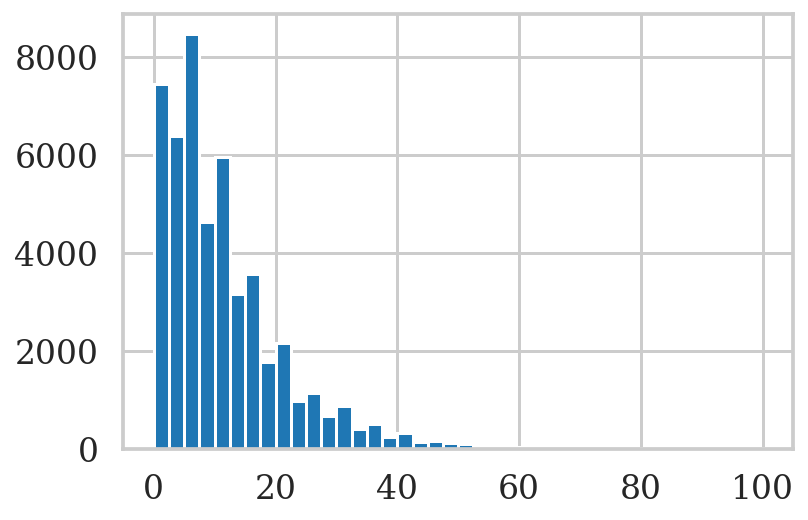

In [38]:
# histogram of customer's years in business
yields.yrs_in_biz.hist(bins=40);

In [39]:
# create 'late_charges' indicator feature
yields.late_charges = np.where(yields.late_charges <=0, 0, 1)

In [40]:
# check for missing
print(yields.pmnts_invoiced.isna().sum())
print(yields.yield_pct.isna().sum())
print(yields.yrs_in_biz.isna().sum())
print(yields.delinq_61.isna().sum())
print(yields.num_assets.isna().sum()) 
print(yields.late_charges.isna().sum())
print(yields.num_contracts.isna().sum())

137
149
146
0
0
0
0


In [42]:
yields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49542 entries, 001-0002253-307 to 099-1529278-002
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pmnts_invoiced  49405 non-null  float64
 1   yield_pct       49393 non-null  float64
 2   yrs_in_biz      49396 non-null  float64
 3   delinq_61       49542 non-null  float64
 4   num_assets      49542 non-null  int64  
 5   late_charges    49542 non-null  int64  
 6   num_contracts   49542 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 3.0+ MB


## create brokers dataset, all above dataset merged

In [43]:
# merge scores, demo, financials and yields datasets together
merge1 = pd.merge(scores, demo, on='contract_num', how='inner')
merge2 = pd.merge(financials, yields, on='contract_num', how='inner')
brokers = pd.merge(merge1, merge2, on='contract_num', how='inner')

In [44]:
brokers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49542 entries, 001-0002253-307 to 099-1529278-002
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   equipment_cost  49542 non-null  float64       
 1   times_delinq    49542 non-null  float64       
 2   delinq_31       49542 non-null  float64       
 3   delinq_91       49542 non-null  float64       
 4   app_score       47965 non-null  float64       
 5   beacon_score    48015 non-null  float64       
 6   city            49542 non-null  object        
 7   state           49542 non-null  object        
 8   zip             49542 non-null  object        
 9   broker_num      49539 non-null  float64       
 10  region          49542 non-null  object        
 11  payment         49542 non-null  float64       
 12  active_date     49542 non-null  datetime64[ns]
 13  terms_months    49494 non-null  float64       
 14  gross           49542 non-null  flo

In [45]:
# only use data from 01-02-2009 onward
mask = brokers.active_date > '2009-01-01'
brokers = brokers[mask].copy()

In [46]:
brokers.shape

(49164, 27)

In [47]:
# drop 'city', 'state', 'zip', 'broker_num'
# brokers.drop(columns=['city', 'state', 'zip', 'broker_num'], inplace=True)
brokers.drop(columns=['broker_num'], inplace=True)

In [48]:
# set the negative 'yield_pct' to NaN
brokers['yield_pct'] = np.where(brokers['yield_pct'] < 0, np.nan, brokers['yield_pct'])

In [49]:
# count number of missing 'yield_pct'
brokers['yield_pct'].isna().sum()

154

In [50]:
# drop any row with a missing value in any column
brokers = brokers.dropna().copy()

In [51]:
brokers.shape

(47639, 26)

In [53]:
# if 'app_score' is zero, set to NaN, will impute median for NaN
brokers['app_score'] = np.where(brokers['app_score'] == 0, np.nan, brokers['app_score'])
brokers.app_score.fillna(brokers.app_score.median(), inplace=True)

In [54]:
# if 'beacon_score' is zero, set to NaN, will impute median for NaN
brokers['beacon_score'] = np.where(brokers['beacon_score'] == 0, np.nan, brokers['beacon_score'])
brokers.beacon_score.fillna(brokers.beacon_score.median(), inplace=True)

In [55]:
brokers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47639 entries, 001-0002253-307 to 015-1654222-301
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   equipment_cost  47639 non-null  float64       
 1   times_delinq    47639 non-null  float64       
 2   delinq_31       47639 non-null  float64       
 3   delinq_91       47639 non-null  float64       
 4   app_score       47639 non-null  float64       
 5   beacon_score    47639 non-null  float64       
 6   city            47639 non-null  object        
 7   state           47639 non-null  object        
 8   zip             47639 non-null  object        
 9   region          47639 non-null  object        
 10  payment         47639 non-null  float64       
 11  active_date     47639 non-null  datetime64[ns]
 12  terms_months    47639 non-null  float64       
 13  gross           47639 non-null  float64       
 14  pmnts_made      47639 non-null  flo

In [56]:
# if the payment and pmnts_made features are 0 drop the obs
mask = np.where(((brokers.payment==0) & (brokers.pmnts_made==0)), False, True)

In [57]:
# total up # of obs to keep
sum(mask)

47544

In [58]:
# filter data
brokers = brokers[mask].copy()

In [59]:
# check that data was filtered ok
brokers.shape

(47544, 26)

## sic code dataset merge with brokers dataset
## feature engineering of 'industry' code

In [60]:
# sic codes matched to osha industry codes data
sic_osha = pd.read_excel('sic_to_osha.xlsx')

In [61]:
# rename columns
sic_osha.rename(columns={'SIC Code': 'sic_code', 'IndustryGroupfromOsha': 'industry'}, inplace=True)

In [62]:
sic_osha.head()

sic_code    industry
0       111  CashGrains
1       112  CashGrains
2       115  CashGrains
3       116  CashGrains
4       119  CashGrains

In [63]:
# merge the brokers dataset with sic_osha dataset on the sic_code
brokers_sic = pd.merge(brokers, sic_osha, on='sic_code', how='left')

In [64]:
# identify any missing data
mask = np.where(pd.isna(brokers_sic.industry), True, False)

In [65]:
brokers_sic.shape

(47544, 27)

In [66]:
# drop any obs with missing industry codes
brokers_sic = brokers_sic[~mask].copy()

In [67]:
brokers_sic.shape

(47543, 27)

In [68]:
# count the number of unique industry codes
brokers_sic.industry.nunique()

277

In [69]:
# copy the brokers_sic merged and cleaned data back to brokers
brokers = brokers_sic.copy()

In [70]:
brokers.columns

Index(['equipment_cost', 'times_delinq', 'delinq_31', 'delinq_91', 'app_score',
       'beacon_score', 'city', 'state', 'zip', 'region', 'payment',
       'active_date', 'terms_months', 'gross', 'pmnts_made', 'amt_recv', 'cbr',
       'sic_code', 'equip_code', 'pmnts_invoiced', 'yield_pct', 'yrs_in_biz',
       'delinq_61', 'num_assets', 'late_charges', 'num_contracts', 'industry'],
      dtype='object')

In [71]:
# make a list of columns to use for bar plots viz
cols_to_plot = ['equipment_cost', 'times_delinq', 'delinq_31', 'delinq_91', 'app_score', 'beacon_score', 
                'region', 'payment', 'terms_months', 'gross', 'pmnts_made', 'amt_recv', 'cbr', 
                'pmnts_invoiced', 'yield_pct', 'yrs_in_biz', 'delinq_61', 'num_assets', 'late_charges', 
                'num_contracts', 'industry']

In [72]:
# create bar plots of selected features
fig, axs = plt.subplots(len(cols_to_plot), figsize=(15,200))
for n, col in enumerate(cols_to_plot):
    plot = brokers[col].hist(ax=axs[n], bins=30, label=col)
    plot.set_xlabel(col, fontsize=20)


In [73]:
# feature engineer log of 'equipment_cost'
# log of feature makes model worse, don't use

# brokers['ln_equipment_cost'] = np.log(brokers.equipment_cost)

In [74]:
# brokers['ln_equipment_cost'].hist();

In [75]:
# feature engineer log of 'gross'
# log of feature makes model worse, don't use

# brokers['ln_gross'] = np.log(brokers.gross)

In [76]:
# brokers['ln_gross'].hist();

In [77]:
# 'payments', 'amt_recv' data too many or negative values or transformed, don't use 'cbr' drop features
brokers.drop(columns=['payment', 'amt_recv', 'cbr'], inplace=True)

In [78]:
# count the frequency of industries in the dataset
industries = brokers.groupby(['industry']).size().sort_values(ascending=False)

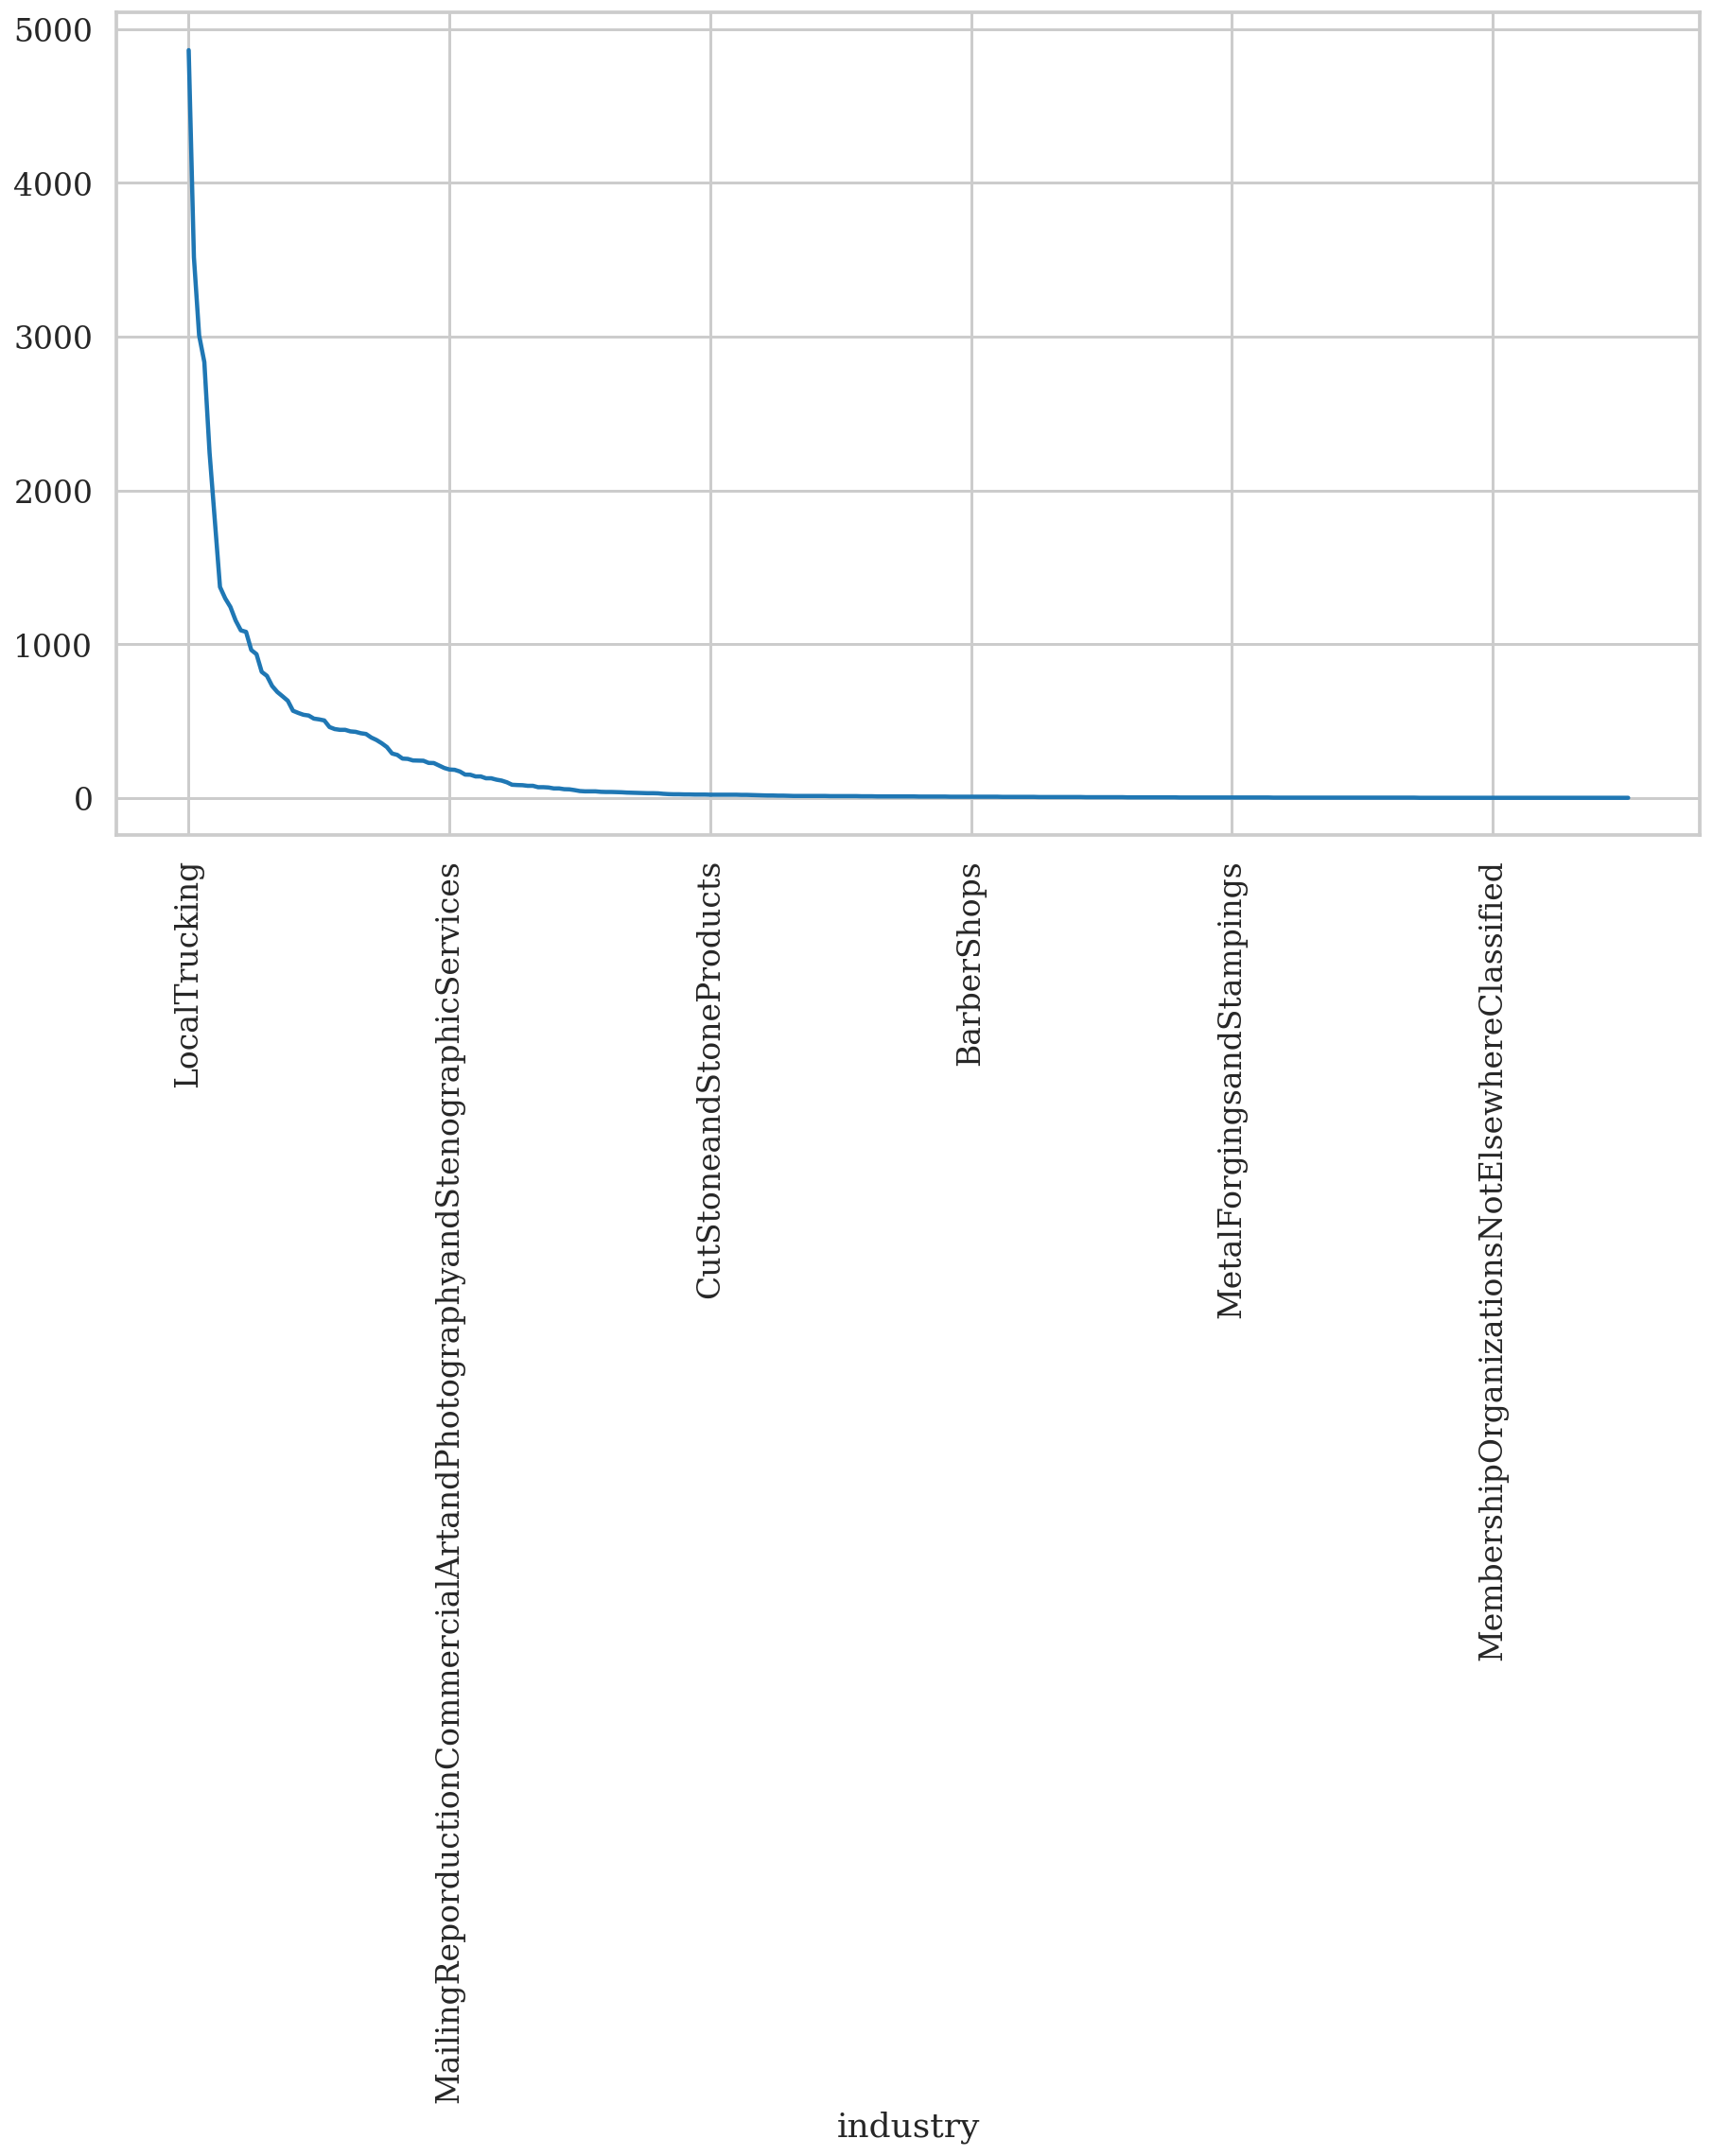

In [79]:
# plot industries frequencies
plt.figure(figsize=(15,8))
industries.plot(rot=90);

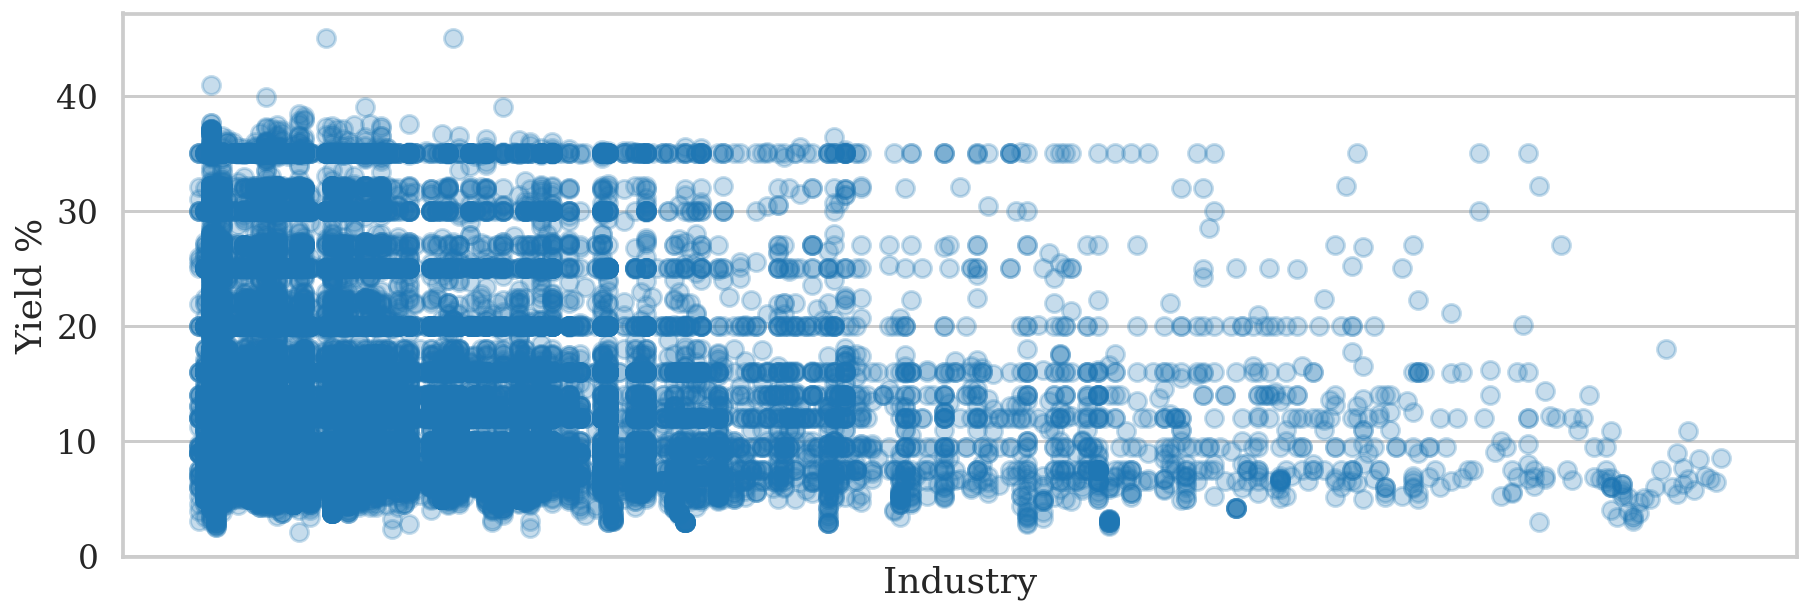

In [80]:
# scatter plot of industry vs yield % (profit)
plt.figure(figsize=(15,5))
plt.scatter(x=brokers.industry, y=brokers.yield_pct, alpha=0.25)
plt.xticks([])
plt.xlabel('Industry')
plt.ylabel('Yield %');

In [81]:
# make industries a DataFrame
ind_df = pd.DataFrame(industries)

In [82]:
ind_df.reset_index(inplace=True)

In [83]:
# only industries with more than 200 entries (~91% of data)
mask = ind_df[0] > 200

In [84]:
# filter for the industries with a 200 frequency or more
ind_df = ind_df[mask].copy()

In [85]:
# make an industry list for filtering
ind_lst = list(ind_df['industry'])

In [86]:
# create filter mask for industry to keep in dataset
mask = brokers['industry'].apply(lambda x: True if x in ind_lst else False)

In [87]:
# filter for only industry with more than 200 entries
brokers = brokers[mask].copy()

In [88]:
brokers.shape

(42883, 24)

In [90]:
# copy this brokers DataFrame for use with Tableau
brokers_tableau = brokers.copy()

In [92]:
# drop 'sic_code', 'equip_code', 'active_date'
brokers.drop(columns=['sic_code', 'equip_code', 'active_date'], inplace=True)

In [93]:
brokers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42883 entries, 1 to 47543
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   equipment_cost  42883 non-null  float64
 1   times_delinq    42883 non-null  float64
 2   delinq_31       42883 non-null  float64
 3   delinq_91       42883 non-null  float64
 4   app_score       42883 non-null  float64
 5   beacon_score    42883 non-null  float64
 6   city            42883 non-null  object 
 7   state           42883 non-null  object 
 8   zip             42883 non-null  object 
 9   region          42883 non-null  object 
 10  terms_months    42883 non-null  float64
 11  gross           42883 non-null  float64
 12  pmnts_made      42883 non-null  float64
 13  pmnts_invoiced  42883 non-null  float64
 14  yield_pct       42883 non-null  float64
 15  yrs_in_biz      42883 non-null  float64
 16  delinq_61       42883 non-null  float64
 17  num_assets      42883 non-null 

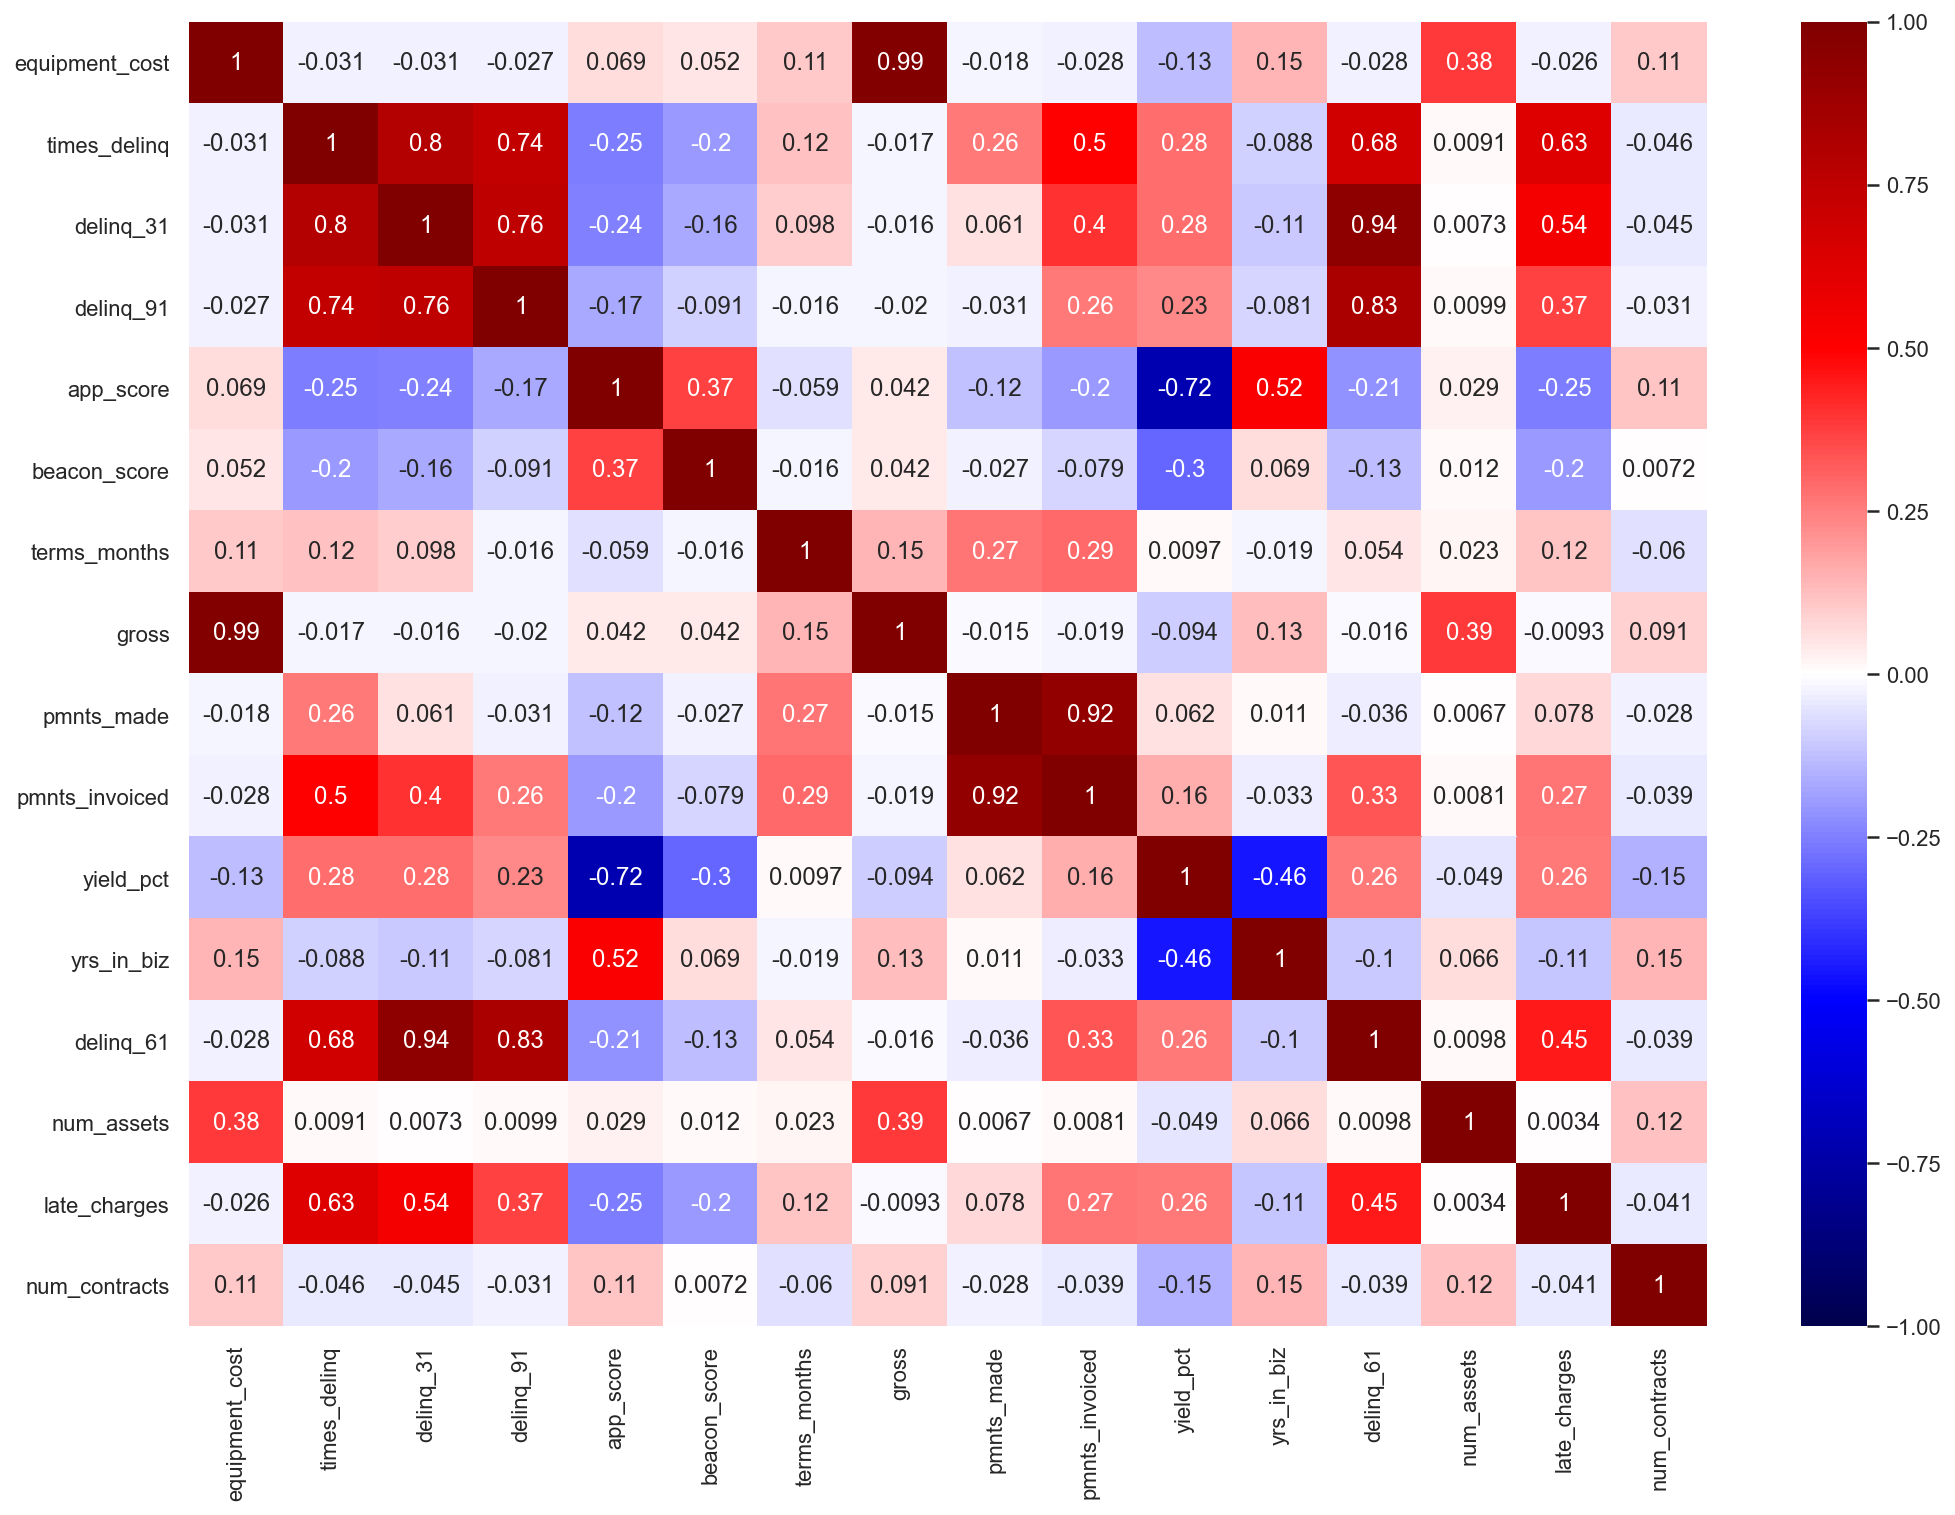

In [96]:
# correlation heatmap of continuous features, without industries
sns.set(font_scale=1.0)
annot_kws={"size": 20}
plt.figure(figsize=(17,12))

sns.heatmap(brokers.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [114]:
# drop 'delinq_31', 'delinq_91', all highly correlated with 'times_delinq', 'pmnts_made' (r=.92 with 'pmnts_invoiced'), 
# 'gross' (r=.99 with 'equipment_cost')
brokers.drop(columns=['delinq_31', 'delinq_91', 'pmnts_made', 'gross'], inplace=True)

In [116]:
# add interaction features
# no interactions resulted in an improved model so they were removed from model

# brokers['yrsbiz_assets'] = (brokers.yrs_in_biz * brokers.num_assets)
# brokers['yrsbiz_app'] = (brokers.yrs_in_biz * brokers.app_score)
# brokers['delinq_contracts'] = (brokers.times_delinq * brokers.num_contracts)
# brokers['delinq_terms'] = (brokers.times_delinq * brokers.terms_months)

In [118]:
# subset brokers to target and only features used for modeling
brokers = brokers[['yield_pct', 'equipment_cost', 'times_delinq', 'app_score', 'beacon_score', 'region', 'terms_months',
                   'pmnts_invoiced', 'yrs_in_biz', 'delinq_61', 'num_assets', 'late_charges', 'num_contracts', 
                   'industry']].copy()

In [120]:
# scatterplots of target vs features
fig = plt.figure(figsize=(48, 88))
ax1 = plt.subplot(6, 2, 1, alpha=.1) 
ax1.scatter(brokers.times_delinq, brokers.yield_pct)
ax1.set_title('Yield v Times Delinq', fontsize=75)

ax2 = plt.subplot(6, 2, 2, sharex=ax1)
ax2.scatter(brokers.app_score, brokers.yield_pct)
ax2.set_title('Yield v App Score', fontsize=75)

ax3 = plt.subplot(6, 2, 3, sharey=ax1)
ax3.scatter(brokers.beacon_score, brokers.yield_pct)
ax3.set_title('Yield v Beacon Score', fontsize=75)

ax4 = plt.subplot(6, 2, 4, sharey=ax1)
ax4.scatter(brokers.terms_months, brokers.yield_pct)
ax4.set_title('Yield v Terms in Months', fontsize=75)

ax5 = plt.subplot(6, 2, 5, sharey=ax1)
ax5.scatter(brokers.pmnts_invoiced, brokers.yield_pct)
ax5.set_title('Yield v Payments Invoiced', fontsize=75)

ax6 = plt.subplot(6, 2, 6, sharey=ax1)
ax6.scatter(brokers.yrs_in_biz, brokers.yield_pct)
ax6.set_title('Yield v Yrs in Business', fontsize=75)

ax7 = plt.subplot(6, 2, 7, sharey=ax1)
ax7.scatter(brokers.num_assets, brokers.yield_pct)
ax7.set_title('Yield v Number of Assets', fontsize=75)

ax8 = plt.subplot(6, 2, 8, sharey=ax1)
ax8.scatter(brokers.late_charges, brokers.yield_pct)
ax8.set_title('Yield v Late Charges', fontsize=75)

ax9 = plt.subplot(6, 2, 9, sharey=ax1)
ax9.scatter(brokers.num_contracts, brokers.yield_pct)
ax9.set_title('Yield v Number of Contracts', fontsize=75)

ax10 = plt.subplot(6, 2, 10, sharey=ax1)
ax10.scatter(brokers.equipment_cost, brokers.yield_pct)
ax10.set_title('Yield v Equipment Cost', fontsize=75)

ax11 = plt.subplot(6, 2, 11, sharey=ax1)
ax11.scatter(brokers.delinq_61, brokers.yield_pct)
ax11.set_title('Yield v Delinq 61', fontsize=75)


fig.tight_layout()


In [121]:
# one-hot encoding to make categorical features into numeric indicator columns in new DataFrame brokers_final
brokers_final = pd.get_dummies(brokers, drop_first=True)

In [122]:
brokers_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42883 entries, 1 to 47543
Data columns (total 64 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   yield_pct                                                    42883 non-null  float64
 1   equipment_cost                                               42883 non-null  float64
 2   times_delinq                                                 42883 non-null  float64
 3   app_score                                                    42883 non-null  float64
 4   beacon_score                                                 42883 non-null  float64
 5   terms_months                                                 42883 non-null  float64
 6   pmnts_invoiced                                               42883 non-null  float64
 7   yrs_in_biz                                                   42883 non-null 

In [123]:
# split data: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(brokers_final.iloc[:, 1:64], brokers_final.iloc[:, 0], 
                                                    test_size = 0.2, random_state=55)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)


In [124]:
X_train.shape

(25729, 63)

In [125]:
#Root Mean Squared Error function
def rmse(preds, actuals):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [126]:
# Mean Absolute Error (MAE) function
def mae(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true))

In [127]:
# scale for Lasso Reg
scaler = StandardScaler()

X_tr_s = scaler.fit_transform(X_train)  
X_test_s = scaler.transform(X_test)


# fit lasso_reg, rf_reg, xgb_reg

In [224]:
# LASSO REG

lasso_reg = Lasso(alpha=.2)
lasso_reg.fit(X_tr_s, y_train)

print('Lasso Train R^2:', lasso_reg.score(X_tr_s, y_train))
print('Lasso Test R^2 :', lasso_reg.score(X_test_s, y_test))

Lasso Train R^2: 0.5723422297531717
Lasso Test R^2 : 0.5713337917451773


In [225]:
# RMSE for Lasso
rmse(lasso_reg.predict(X_test), y_test)

28041.187865448668

In [226]:
# LASSO CV scoring
lasso_cv = cross_val_score(lasso_reg, X_tr_s, y_train, scoring='r2', cv=10)
print('Lasso CV Mean R^2  :', lasso_cv.mean(), '\u00B1', lasso_cv.std())


Lasso CV Mean R^2  : 0.5715089464031868 ± 0.011449725232545237


In [227]:
# RF REG

rf_reg = RandomForestRegressor(n_estimators=40, max_depth=8, max_features='auto', random_state = 55)
rf_reg.fit(X_train, y_train)

print('RF Train R^2:', rf_reg.score(X_train, y_train))
print('RF Test R^2 :', rf_reg.score(X_test, y_test))

RF Train R^2: 0.8250679960038312
RF Test R^2 : 0.8037587317550403


In [228]:
# RMSE for RF
rmse(rf_reg.predict(X_test), y_test)

3.5202425015853147

In [229]:
# RF REG CV scoring
rf_cv = cross_val_score(rf_reg, X_train, y_train, scoring='r2', cv=10)
print('RF CV Mean R^2  :', rf_cv.mean(), '+/-', rf_cv.std())


RF CV Mean R^2  : 0.7992540204435798 +/- 0.016316596483655903


In [230]:
# XGB REG

xgb_reg = xgb.XGBRegressor(n_estimators=100, 
                           learning_rate=0.08, 
                           gamma=0, 
                           reg_lambda=0.8, 
                           reg_alpha=0.005, 
                           objective="reg:squarederror", 
                           subsample=0.75, 
                           colsample_bytree=.7, 
                           max_depth=7)

xgb_reg.fit(X_train,y_train)

print('XGB Train R^2:', xgb_reg.score(X_train, y_train))
print('XGB Test R^2 :', xgb_reg.score(X_test, y_test))

XGB Train R^2: 0.8859504479377386
XGB Test R^2 : 0.8391707787000261


In [231]:
# RMSE for XGB
rmse(xgb_reg.predict(X_test), y_test)

3.1868372929508877

In [232]:
# XGB REG CV scoring
xgb_cv = cross_val_score(xgb_reg, X_train, y_train, scoring='r2', cv=5)
print('XGB CV Mean R^2  :', xgb_cv.mean(), '+/-', xgb_cv.std())


XGB CV Mean R^2  : 0.8322172519623718 +/- 0.00831087464765453


# XGBoost is the winner
## feature importance and feature selection

In [233]:
# tune the XGBRegressor hyperparameters
xgb_tune = xgb.XGBRegressor()

parameters = {'objective': ['reg:squarederror'],
              'gamma': [0],
              'reg_lambda': [0.6],
              'reg_alpha': [0.05],
              'learning_rate': [.06],
              'max_depth': [7],
              'min_child_weight': [8],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_tune,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:   12.0s finished


0.8310582829882246
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.06, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 500, 'objective': 'reg:squarederror', 'reg_alpha': 0.05, 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.7}


In [234]:
# cross-validation of best parameters from tuning
xgb_best = xgb.XGBRegressor(objective='reg:squarederror',
                            gamma=0, 
                            reg_lambda=0.6, 
                            reg_alpha=0.05,
                            learning_rate=0.06,
                            max_depth=7, 
                            min_child_weight=8,
                            silent=1, 
                            subsample=0.7,
                            colsample_bytree=.8, 
                            n_estimators=30000
                           )

eval_set=[(X_train,y_train),(X_val,y_val)]  # train/validation error

fit_model = xgb_best.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True
                   )

[0]	validation_0-rmse:14.98184	validation_1-rmse:15.11094
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:14.24898	validation_1-rmse:14.38227
[2]	validation_0-rmse:13.45269	validation_1-rmse:13.58138
[3]	validation_0-rmse:12.71883	validation_1-rmse:12.84247
[4]	validation_0-rmse:12.01706	validation_1-rmse:12.13605
[5]	validation_0-rmse:11.36182	validation_1-rmse:11.47649
[6]	validation_0-rmse:10.74865	validation_1-rmse:10.85996
[7]	validation_0-rmse:10.21117	validation_1-rmse:10.32333
[8]	validation_0-rmse:9.67582	validation_1-rmse:9.78527
[9]	validation_0-rmse:9.17439	validation_1-rmse:9.28087
[10]	validation_0-rmse:8.70744	validation_1-rmse:8.81194
[11]	validation_0-rmse:8.26933	validation_1-rmse:8.37120
[12]	validation_0-rmse:7.88473	validation_1-rmse:7.98488
[13]	validation_0-rmse:7.50464	validation_1-rmse:7.60359
[14]	validation_0-rmse:7.15604	valida

[141]	validation_0-rmse:2.76440	validation_1-rmse:3.12173
[142]	validation_0-rmse:2.76325	validation_1-rmse:3.12168
[143]	validation_0-rmse:2.76106	validation_1-rmse:3.12040
[144]	validation_0-rmse:2.75679	validation_1-rmse:3.11845
[145]	validation_0-rmse:2.75407	validation_1-rmse:3.11856
[146]	validation_0-rmse:2.75166	validation_1-rmse:3.11826
[147]	validation_0-rmse:2.74985	validation_1-rmse:3.11794
[148]	validation_0-rmse:2.74644	validation_1-rmse:3.11725
[149]	validation_0-rmse:2.74243	validation_1-rmse:3.11638
[150]	validation_0-rmse:2.73759	validation_1-rmse:3.11383
[151]	validation_0-rmse:2.73557	validation_1-rmse:3.11363
[152]	validation_0-rmse:2.73134	validation_1-rmse:3.11218
[153]	validation_0-rmse:2.73033	validation_1-rmse:3.11210
[154]	validation_0-rmse:2.72646	validation_1-rmse:3.11083
[155]	validation_0-rmse:2.72362	validation_1-rmse:3.11042
[156]	validation_0-rmse:2.72243	validation_1-rmse:3.11035
[157]	validation_0-rmse:2.72062	validation_1-rmse:3.10979
[158]	validati

[283]	validation_0-rmse:2.44110	validation_1-rmse:3.06718
[284]	validation_0-rmse:2.43815	validation_1-rmse:3.06718
[285]	validation_0-rmse:2.43639	validation_1-rmse:3.06711
[286]	validation_0-rmse:2.43342	validation_1-rmse:3.06692
[287]	validation_0-rmse:2.43275	validation_1-rmse:3.06710
[288]	validation_0-rmse:2.43174	validation_1-rmse:3.06685
[289]	validation_0-rmse:2.43036	validation_1-rmse:3.06652
[290]	validation_0-rmse:2.42907	validation_1-rmse:3.06646
[291]	validation_0-rmse:2.42622	validation_1-rmse:3.06668
[292]	validation_0-rmse:2.42355	validation_1-rmse:3.06625
[293]	validation_0-rmse:2.42144	validation_1-rmse:3.06604
[294]	validation_0-rmse:2.41751	validation_1-rmse:3.06584
[295]	validation_0-rmse:2.41607	validation_1-rmse:3.06584
[296]	validation_0-rmse:2.41513	validation_1-rmse:3.06577
[297]	validation_0-rmse:2.41320	validation_1-rmse:3.06565
[298]	validation_0-rmse:2.41122	validation_1-rmse:3.06511
[299]	validation_0-rmse:2.40990	validation_1-rmse:3.06531
[300]	validati

In [119]:
# get the RMSE from the best XGB model
rmse(xgb_best.predict(X_test, ntree_limit=xgb_best.best_ntree_limit), y_test)

3.1183695905373816

In [128]:
# create the final XGB model with best n_estimators (lowest RMSE)
xgb_final = xgb.XGBRegressor(objective='reg:squarederror',
                            gamma=0, 
                            reg_lambda=0.6, 
                            reg_alpha=0.05,
                            learning_rate=0.06,
                            max_depth=7, 
                            min_child_weight=8,
                            silent=1, 
                            subsample=0.7,
                            colsample_bytree=0.8, 
                            n_estimators=364
                           )

fit_final = xgb_final.fit(X_train,y_train)

In [129]:
print(rmse(xgb_final.predict(X_test), y_test))
print(mae(xgb_final.predict(X_test), y_test))

3.1117810800242562
1.9695343880265888


In [130]:
# R^2 for train, test and val
print('XGB Best Train R^2:', xgb_final.score(X_train, y_train))
print('XGB Best Test R^2 :', xgb_final.score(X_test, y_test))
print('XGB Best Val R^2  :', xgb_final.score(X_val, y_val))

XGB Best Train R^2: 0.9183165358717088
XGB Best Test R^2 : 0.8466572492599092
XGB Best Val R^2  : 0.8579872191466174


<Figure size 1080x2880 with 0 Axes>

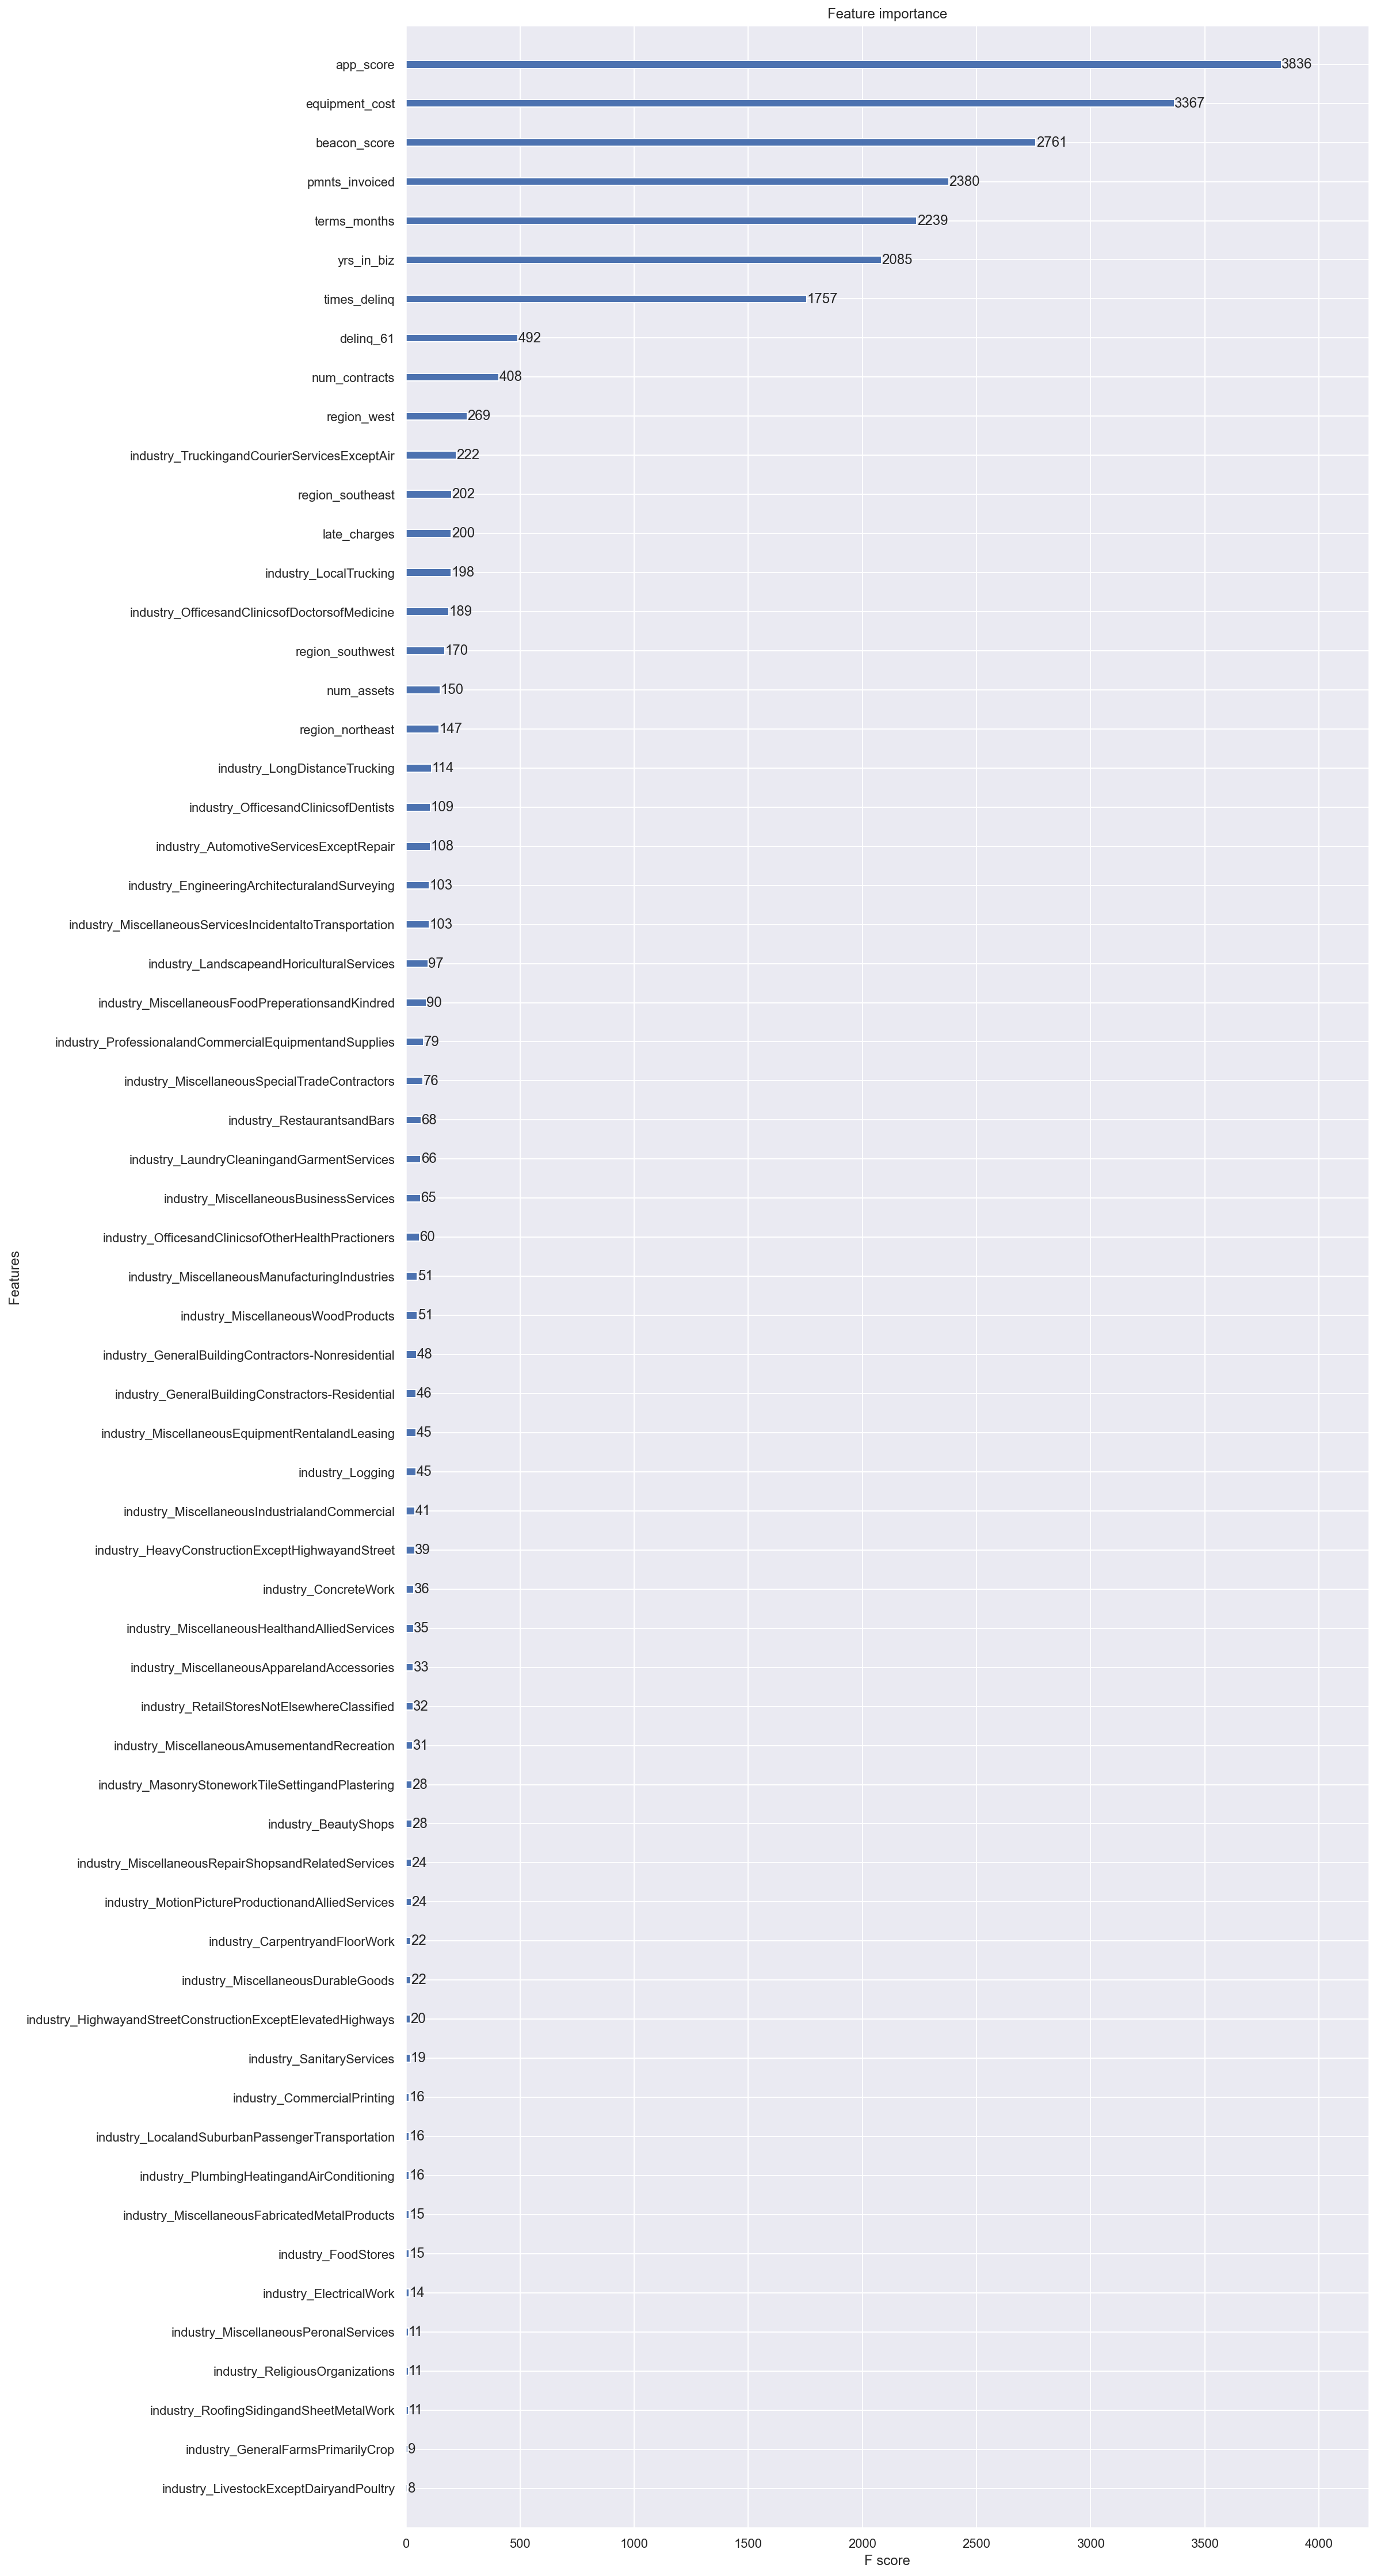

In [131]:
# XGB feature importance plot of ‘weight’ - the number of times a feature is used to split the data across all trees
plt.figure(figsize(15, 40))
plot_importance(xgb_final)
plt.show()

<Figure size 1080x2880 with 0 Axes>

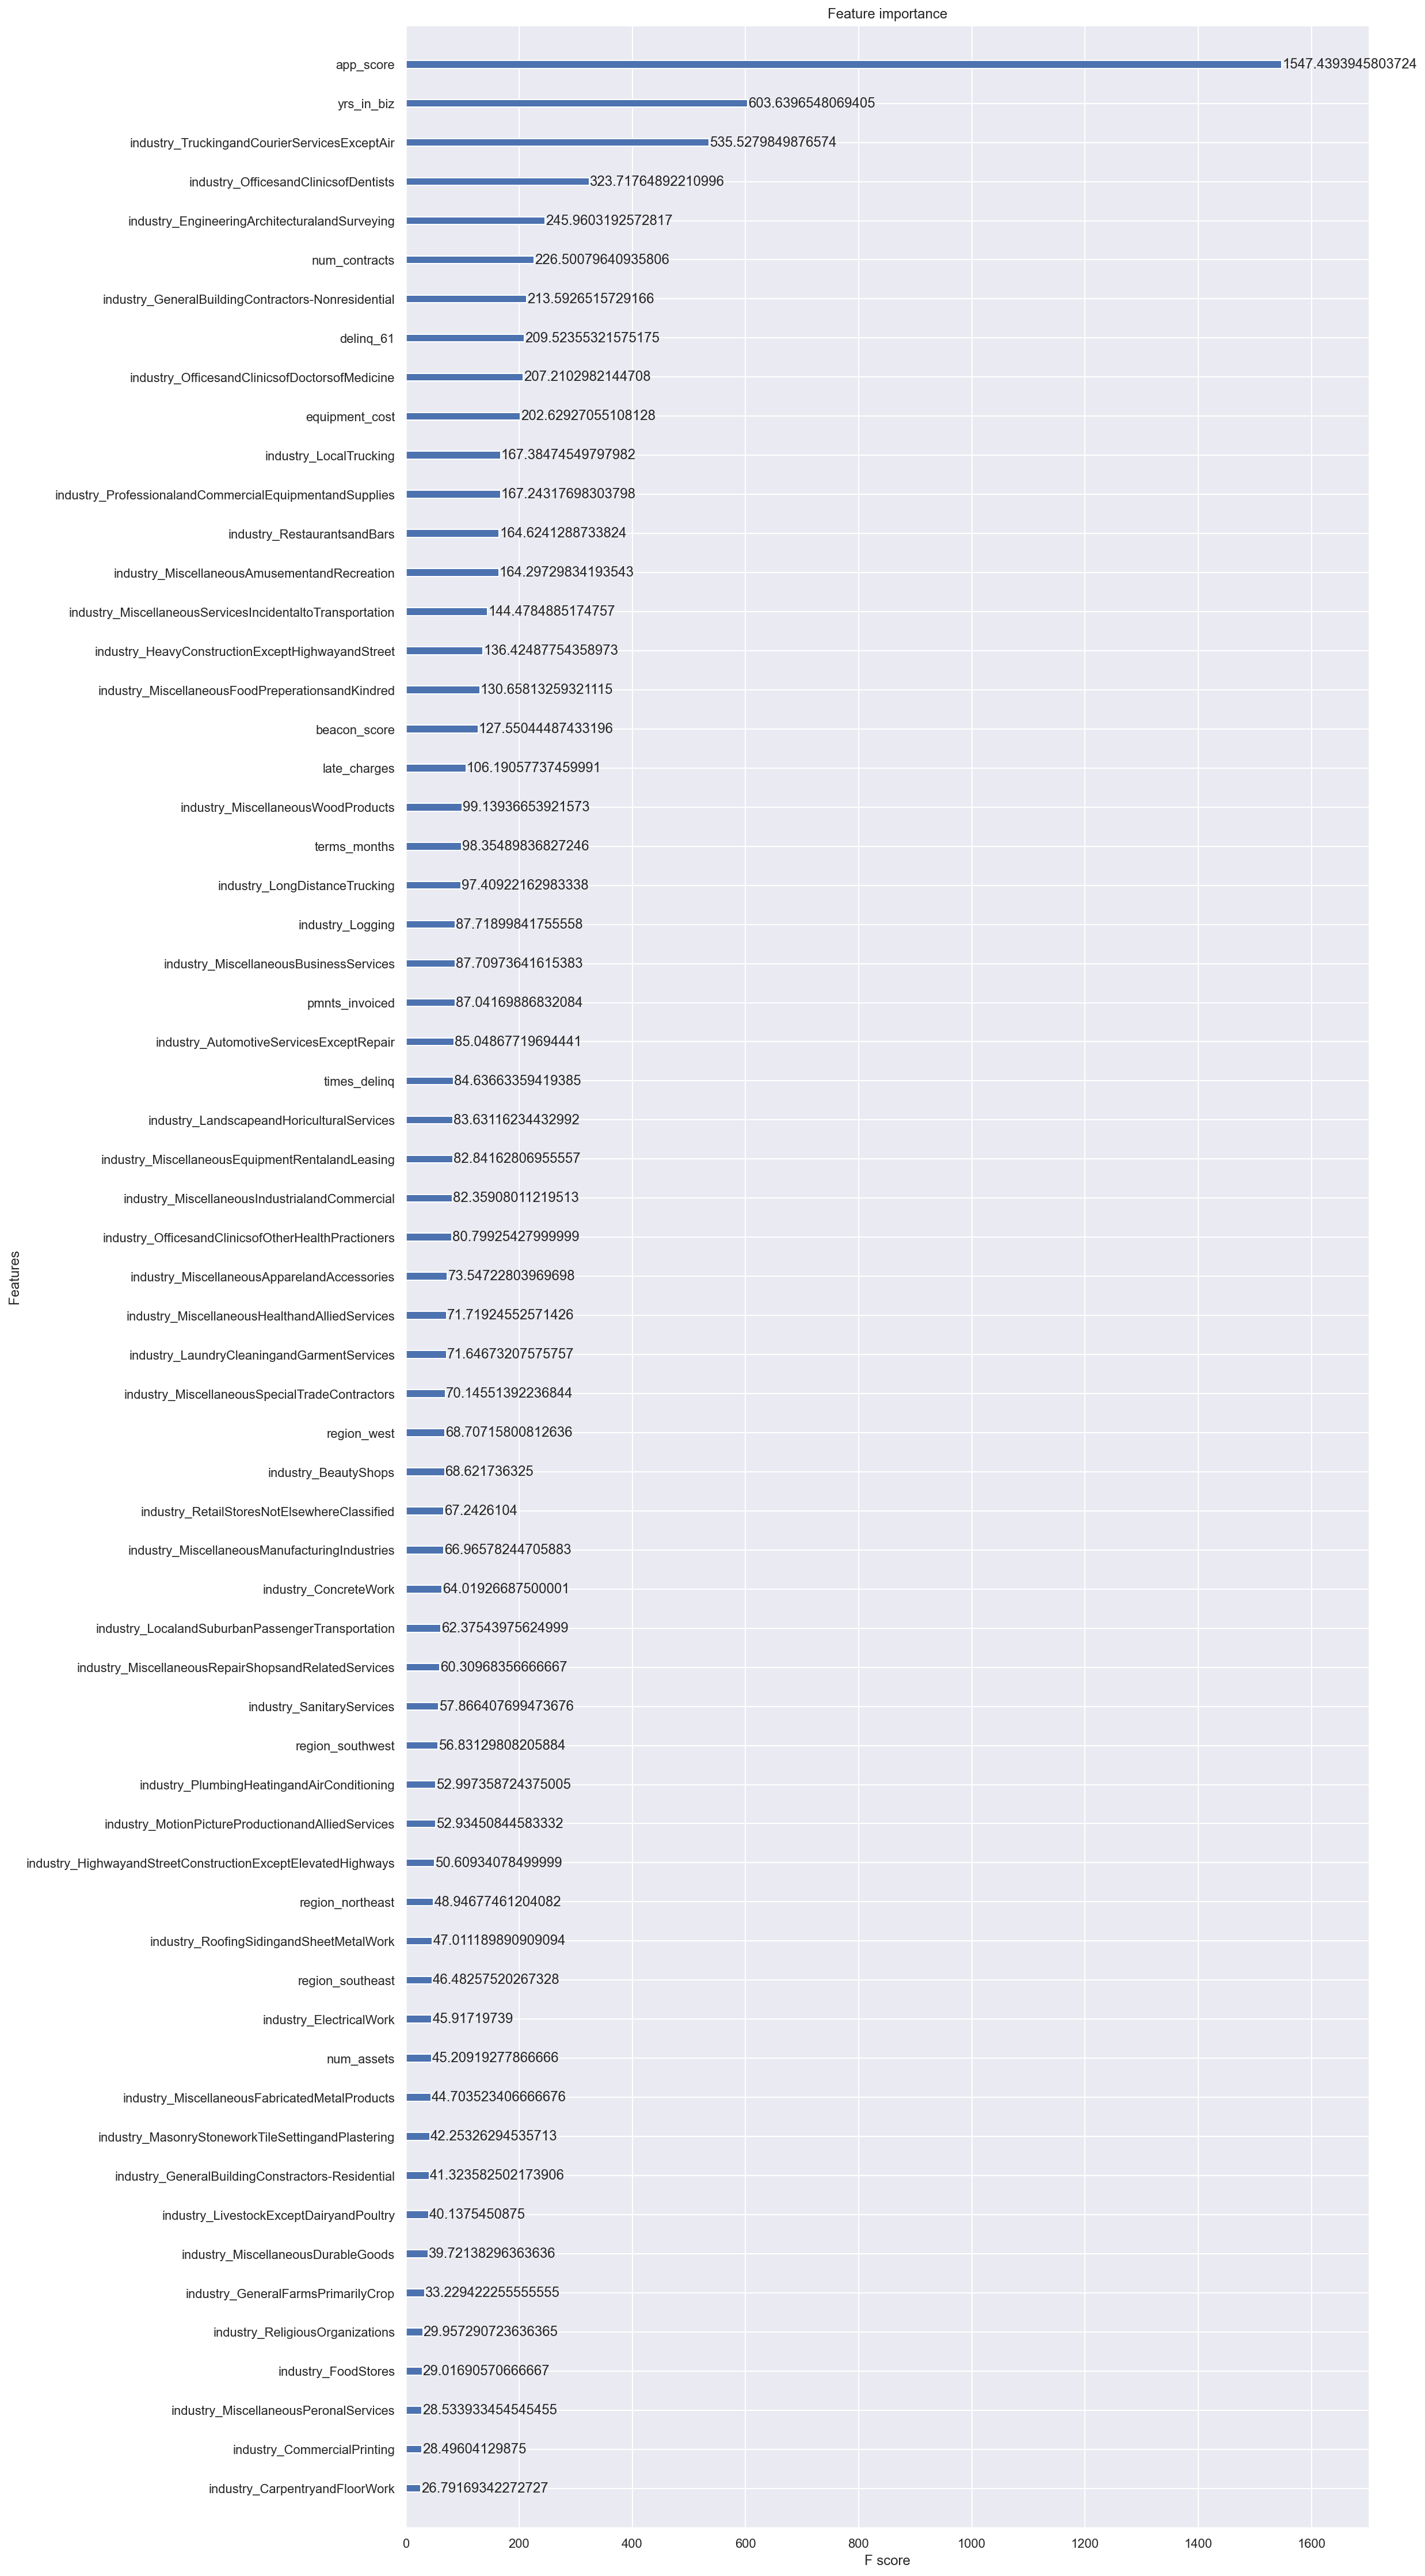

In [132]:
# XGB feature importance plot of ‘gain’ - the average gain across all splits the feature is used in
plt.figure(figsize(15, 40))
plot_importance(xgb_final, importance_type='gain')
plt.show()

In [133]:
# get the top ten features
from collections import Counter

x = Counter(xgb_final.get_booster().get_score(importance_type='gain'))
x.most_common(10)

[('app_score', 1547.4393945803724),
 ('yrs_in_biz', 603.6396548069405),
 ('industry_TruckingandCourierServicesExceptAir', 535.5279849876574),
 ('industry_OfficesandClinicsofDentists', 323.71764892210996),
 ('industry_EngineeringArchitecturalandSurveying', 245.9603192572817),
 ('num_contracts', 226.50079640935806),
 ('industry_GeneralBuildingContractors-Nonresidential', 213.5926515729166),
 ('delinq_61', 209.52355321575175),
 ('industry_OfficesandClinicsofDoctorsofMedicine', 207.2102982144708),
 ('equipment_cost', 202.62927055108128)]

<Figure size 432x432 with 0 Axes>

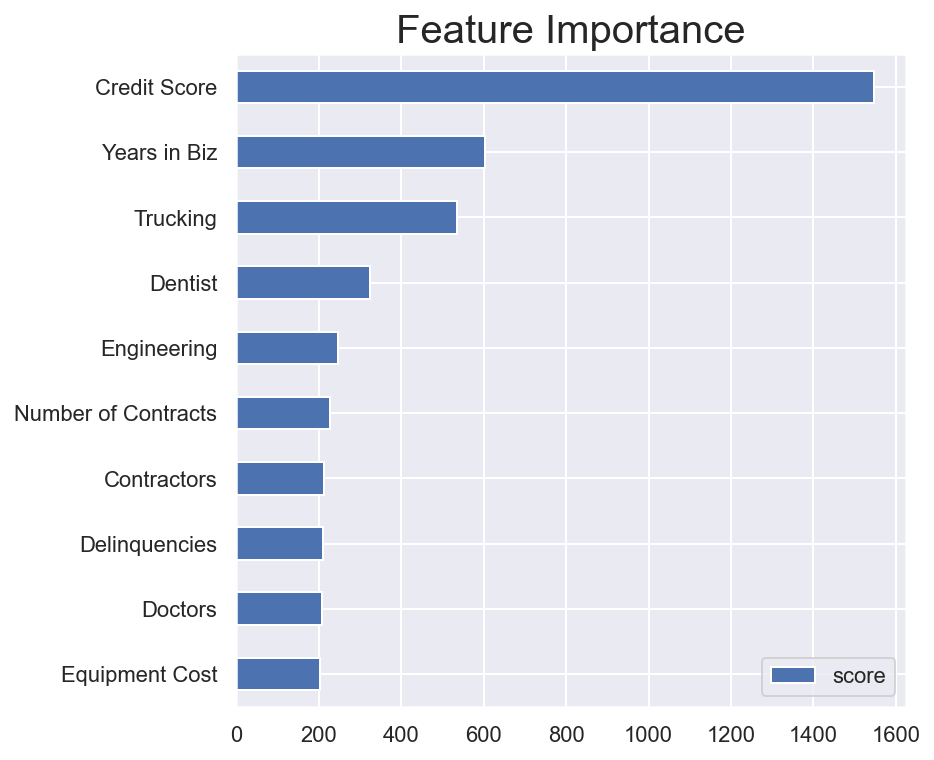

In [134]:
# plot the top ten feature importance gain
x = Counter(xgb_final.get_booster().get_score(importance_type='gain'))
feature_important = dict(x.most_common(10))
keys = feature_important.keys()

new_keys = (['Credit Score', 'Years in Biz', 'Trucking', 'Dentist', 'Engineering', 'Number of Contracts', 
             'Contractors', 'Delinquencies', 'Doctors', 'Equipment Cost'])

values = feature_important.values()

data = pd.DataFrame(data=values, index=new_keys, columns=["score"]).sort_values(by = "score")

plt.figure(figsize(6, 6))
data.plot(kind='barh')
plt.title('Feature Importance', fontsize=20);

In [137]:
# save DataFrame to an Excel file for prettier plotting
data.to_excel('feature_importance.xlsx')

In [248]:
# copy top ten features data to X DataFrame
X = brokers_final[['app_score', 'yrs_in_biz', 'industry_TruckingandCourierServicesExceptAir', 
                   'industry_OfficesandClinicsofDentists', 'industry_EngineeringArchitecturalandSurveying', 
                   'num_contracts', 'industry_GeneralBuildingContractors-Nonresidential', 'delinq_61', 
                   'industry_OfficesandClinicsofDoctorsofMedicine', 'equipment_cost']].copy()
X.rename(columns={
    'industry_GeneralBuildingContractors-Nonresidential': 'industry_GeneralBuildingContractors_Nonresidential'},
        inplace=True)

# copy yield_pct to y Series
y = brokers_final[['yield_pct']]

# train/test split of X andy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

In [249]:
# instantiate and fit reduced XGB model with top ten features
xgb_final_reduced = xgb.XGBRegressor(objective='reg:squarederror',
                            gamma=0, 
                            reg_lambda=0.6, 
                            reg_alpha=0.05,
                            learning_rate=0.06,
                            max_depth=7, 
                            min_child_weight=8,
                            silent=1, 
                            subsample=0.7,
                            colsample_bytree=0.8, 
                            n_estimators=364
                           )

fit_final_reduced = xgb_final_reduced.fit(X_train, y_train)

print('XGB Reduced R^2:', xgb_final_reduced.score(X_train, y_train))
print('XGB Reduced R^2:', xgb_final_reduced.score(X_test, y_test))

XGB Reduced R^2: 0.8588845360044359
XGB Reduced R^2: 0.7974109525519262


In [250]:
# pickle fit_model
pickle.dump(fit_final_reduced, open("my_pickled_model.p", "wb"))

### calc the ranges of the continuous features for streamlit slider display

In [252]:
print('App Score:', X.app_score.min(), X.app_score.max())

App Score: 428.0 1041.0


In [253]:
print('Years in Business:', X.yrs_in_biz.min(), X.yrs_in_biz.max())

Years in Business: 0.0 100.0


In [254]:
print('Number of Contracts:', X.num_contracts.min(), X.num_contracts.max())

Number of Contracts: 1 21


In [255]:
print('Equipment Cost:', X.equipment_cost.min(), X.equipment_cost.max())

Equipment Cost: 1054.0 9623398.9


In [263]:
print('Delinq 61:', X.delinq_61.min(), X.delinq_61.max())

Delinq 61: 0.0 59.0


In [256]:
# break the brokers_final DataFrame into features (X) and target(y)
X = brokers_final.iloc[:, 1:64]
y = brokers_final.iloc[:, 0]

In [257]:
# fit the final model to all the data
xgb_final.fit(X, y)
yield_pred = xgb_final.predict(X)

In [339]:
# add predictions to Tableau DataFrame
brokers_tableau['yield_pred'] = yield_pred[:]

In [340]:
# add residuals to Tableau DataFrame
brokers_tableau['residual'] = (brokers_tableau['yield_pct'] - brokers_tableau['yield_pred'])

In [343]:
#brokers_tableau.to_excel('brokers_tableau.xlsx', index=False)

In [5]:
# make active_date the index for aggregating
import datetime

yield_date = brokers_tableau[['yield_pct', 'active_date']]

yield_date.index = yield_date['active_date']

In [6]:
# calc mean annual Profit %
yield_yearly_avg = yield_date.resample('Y').mean()

In [9]:
# save DataFrame to an Excel file
yield_yearly_avg.to_excel('yield_yearly_avg.xlsx')

Text(0, 0.5, 'Yield %')

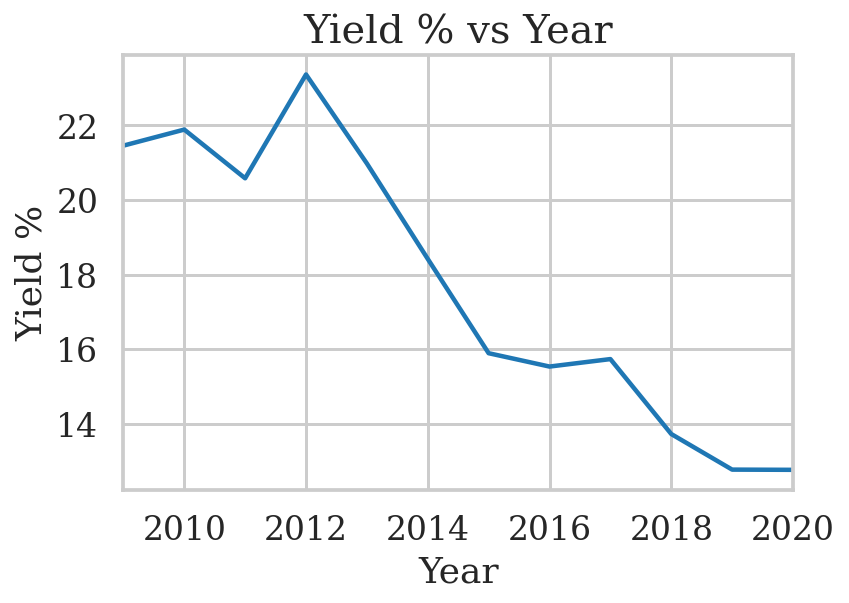

In [7]:
# plot Annual Yield (profit) over time
yield_yearly_avg.yield_pct.plot(use_index=True)
plt.title('Yield % vs Year', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Yield %')

In [11]:
# make a DataFrame of num_contracts and active_date
contracts_date = brokers_tableau[['num_contracts', 'active_date']]

# make active_date the index for aggregation
contracts_date.index = contracts_date['active_date']

# calc annual mean number of loan contracts
contracts_yearly_cnt = contracts_date.resample('Y').count()

Text(0, 0.5, '# of Loans')

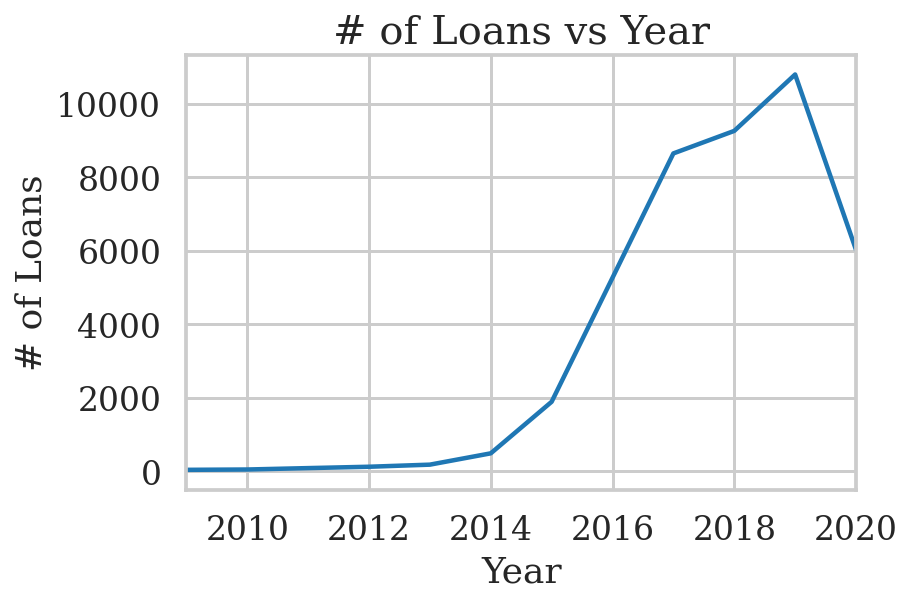

In [12]:
# plot of annual # of loan contracts over time
contracts_yearly_cnt.num_contracts.plot(use_index=True)
plt.title('# of Loans vs Year', fontsize=20)
plt.xlabel('Year')
plt.ylabel('# of Loans')

In [13]:
# save the DataFrame to an Excel file
contracts_yearly_cnt.to_excel('contracts_yearly_cnt.xlsx')